[View in Colaboratory](https://colab.research.google.com/github/navarmn/Wind_turbine_failure_prediction/blob/master/notebook_01_SCIG_7classes_tensorflow.ipynb)

In [1]:
# Imports of libraries and frameworks:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

# Set the random seed for reproducibility

seed = 69
np.random.seed(seed)
tf.set_random_seed(seed)

Using TensorFlow backend.


Load dataset:

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving v000_SCIG_SC_SENSORC_FOURIER_010.csv to v000_SCIG_SC_SENSORC_FOURIER_010.csv
User uploaded file "v000_SCIG_SC_SENSORC_FOURIER_010.csv" with length 635470 bytes


In [0]:
dataset = pd.read_csv('v000_SCIG_SC_SENSORC_FOURIER_010.csv');

In [4]:
dataset.head()

,idx,fx1_R,fx0d5_R,fx1d5_R,fx2d5_R,fx3_R,fx5_R,fx7_R,fx1_S,fx0d5_S,...,fx7_T,Freq_Rated,Freq_Gen,CC_bus,Power,I_R_rms,I_S_rms,I_T_rms,Load,Class
0,1,1.0,0.007299,0.006626,0.000968,0.023378,0.023553,0.006339,1.0,0.007219,...,0.006059,45.0,43.85,369,0.57,2.906343,2.920356,2.986445,0,1
1,2,1.0,0.003416,0.006184,0.001155,0.023907,0.013409,0.005977,1.0,0.003368,...,0.005722,45.0,43.87,368,0.55,2.885150,2.896358,2.962763,0,1
2,3,1.0,0.003490,0.004380,0.000786,0.018111,0.011143,0.005009,1.0,0.003484,...,0.004889,45.0,43.89,367,0.55,2.851384,2.863890,2.935414,0,1
3,4,1.0,0.002984,0.002304,0.000533,0.019345,0.014027,0.004023,1.0,0.002979,...,0.003913,45.0,43.91,365,0.53,2.819084,2.827510,2.900116,0,1
4,5,1.0,0.004993,0.004015,0.001150,0.025392,0.018566,0.004693,1.0,0.004956,...,0.004557,45.0,43.93,363,0.52,2.761420,2.774290,2.844834,0,1


Remove unwanted features

In [5]:
unwanteFeatures = ['idx', 'fx1_R', 'fx1_S', 'fx1_T', 'Freq_Rated', 'Power']
dataset_important_features = dataset.drop(unwanteFeatures, axis=1)

dataset_important_features.head()

,fx0d5_R,fx1d5_R,fx2d5_R,fx3_R,fx5_R,fx7_R,fx0d5_S,fx1d5_S,fx2d5_S,fx3_S,...,fx3_T,fx5_T,fx7_T,Freq_Gen,CC_bus,I_R_rms,I_S_rms,I_T_rms,Load,Class
0,0.007299,0.006626,0.000968,0.023378,0.023553,0.006339,0.007219,0.006553,0.000958,0.023122,...,0.022347,0.022515,0.006059,43.85,369,2.906343,2.920356,2.986445,0,1
1,0.003416,0.006184,0.001155,0.023907,0.013409,0.005977,0.003368,0.006097,0.001139,0.023569,...,0.022888,0.012837,0.005722,43.87,368,2.885150,2.896358,2.962763,0,1
2,0.003490,0.004380,0.000786,0.018111,0.011143,0.005009,0.003484,0.004373,0.000785,0.018082,...,0.017678,0.010877,0.004889,43.89,367,2.851384,2.863890,2.935414,0,1
3,0.002984,0.002304,0.000533,0.019345,0.014027,0.004023,0.002979,0.002300,0.000532,0.019312,...,0.018814,0.013642,0.003913,43.91,365,2.819084,2.827510,2.900116,0,1
4,0.004993,0.004015,0.001150,0.025392,0.018566,0.004693,0.004956,0.003986,0.001141,0.025204,...,0.024655,0.018027,0.004557,43.93,363,2.761420,2.774290,2.844834,0,1


In [6]:
# X are the inputs and y the outputs:

X = dataset_important_features.values[:,:-1]
y = dataset_important_features.values[:,-1]

print(y)

[1. 1. 1. ... 7. 7. 7.]


In [7]:
import numpy as np
Y = np.array(y)

Y-=1
Y

array([0., 0., 0., ..., 6., 6., 6.])

In [8]:
y = keras.utils.to_categorical(Y, num_classes=7)
print(y)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Preprocessing data with standardization

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler();
std_scaler.fit(X)

X = std_scaler.transform(X)

## Training with 10-fold Cross Validation, tensorflow and keras

In [10]:
print(tf.__version__)

1.11.0


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

### Create a keras model

Define, optimzer, loss and mectrics

In [0]:
model = Sequential()

model.add(Dense(10, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(7, activation='softmax'))
          

model.compile(optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [17]:
history=model.fit(X_train, y_train, epochs=300, verbose=1,validation_data=(X_test, y_test))

Train on 1084 samples, validate on 272 samples
Epoch 1/300
1084/1084 [==============================] - 0s 234us/step - loss: 0.7304 - acc: 0.6697 - val_loss: 0.7541 - val_acc: 0.6507
Epoch 2/300
1084/1084 [==============================] - 0s 231us/step - loss: 0.7225 - acc: 0.6614 - val_loss: 0.7434 - val_acc: 0.6765
Epoch 3/300
1084/1084 [==============================] - 0s 243us/step - loss: 0.7131 - acc: 0.6817 - val_loss: 0.7354 - val_acc: 0.6654
Epoch 4/300
1084/1084 [==============================] - 0s 238us/step - loss: 0.7050 - acc: 0.6817 - val_loss: 0.7261 - val_acc: 0.6728
Epoch 5/300
1084/1084 [==============================] - 0s 234us/step - loss: 0.6983 - acc: 0.6836 - val_loss: 0.7245 - val_acc: 0.6801
Epoch 6/300
1084/1084 [==============================] - 0s 229us/step - loss: 0.6912 - acc: 0.6808 - val_loss: 0.7182 - val_acc: 0.6728
Epoch 7/300
1084/1084 [==============================] - 0s 229us/step - loss: 0.6833 - acc: 0.6827 - val_loss: 0.7105 - val_acc: 0

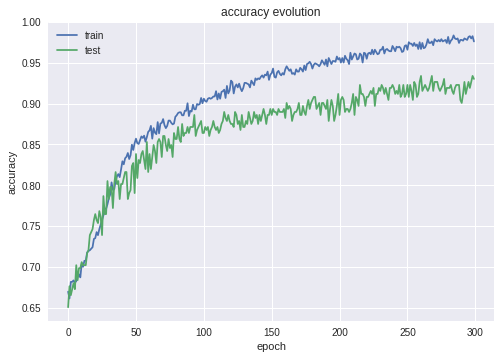

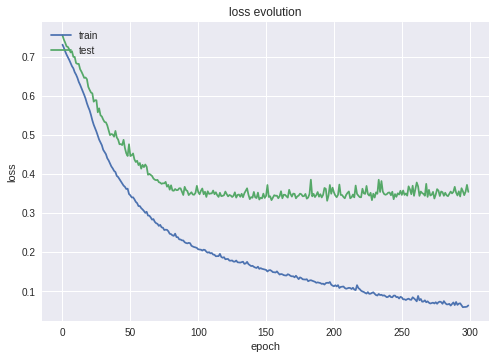

True

In [18]:
def plot_history(history,show=True):
  

    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.grid(True)
    plt.title('accuracy evolution')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    if (show): 
      plt.show()
    else: 
      plt.clf()
      
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid(True)
    plt.title('loss evolution')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    if (show): 
      plt.show()
    else: 
      plt.clf()

    return True

import seaborn as sns

plot_history(history.history,show=True)

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

272/272 [==============================] - 0s 84us/step
Test accuracy: 0.9301470588235294


In [0]:
y_hat = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

In [32]:
def percentage_confusion_matrix (mat):
    return np.around(100*(mat / mat.sum(axis=1)[:,None]), 2)

from sklearn.metrics import confusion_matrix

percentage_confusion_matrix(confusion_matrix(y_test, y_hat))

array([[100.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,  83.33,   0.  ,   0.  ,  13.89,   2.78,   0.  ],
       [  0.  ,   2.63,  92.11,   0.  ,   2.63,   2.63,   0.  ],
       [  0.  ,   0.  ,   0.  , 100.  ,   0.  ,   0.  ,   0.  ],
       [  4.  ,  20.  ,   4.  ,   0.  ,  72.  ,   0.  ,   0.  ],
       [  0.  ,   1.85,   1.85,   0.  ,   0.  ,  94.44,   1.85],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 100.  ]])